# Checkerboard Dataset

Checkerboard dataset subject to unsupervised generation by 4 models:

1. Denoising Score Matching (DSM)
2. Denoising Diffusion Probabilistic Model (DDPM)
3. Generative Adversarial Networks (GAN)
4. Energy Based Model (EBM)

In [1]:
## importing required libraries
from typing import Callable, Iterator, Sequence
import functools

import numpy as np
import scipy as sp
from scipy.stats import gaussian_kde
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax.scipy as jsp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm

In [2]:
## importing auxillary python modules
from dataset_generators import *
from utils import *
from dsm import *
from ddpm import *
from gan import *
from ebm import *

## 1. Dataset

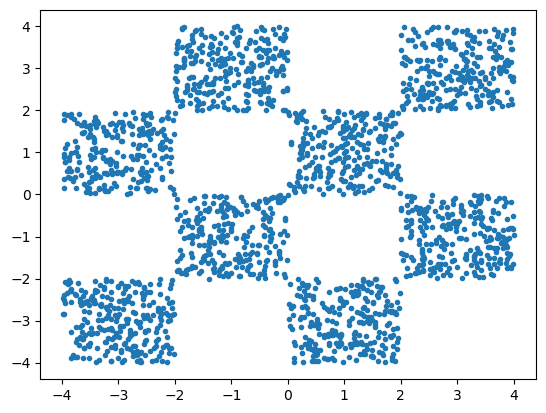

In [3]:
X_checker = generate_checkerboard(num=2000, rng=rng)
plt.plot(X_checker[:, 0], X_checker[:, 1], '.')

## 2. Models

In [4]:
## global variables
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))
noise = 2 * jax.random.normal(next(prng_seq), shape=(2000, 2))

### 2.1 Denoising Score Matching (DSM)

In [5]:
dsm_model = DSM_MLP(features=[128, 128, 2])
step_size = 5e-3
num_steps = 2000

print(dsm_model.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))


                                DSM_MLP Summary                                 
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs         ┃ outputs        ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DSM_MLP │ float32[1,2]   │ float32[1,2]   │                        │
├─────────┼─────────┼────────────────┼────────────────┼────────────────────────┤
│ Dense_0 │ Dense   │ float32[1,2]   │ float32[1,128] │ bias: float32[128]     │
│         │         │                │                │ kernel: float32[2,128] │
│         │         │                │                │                        │
│         │         │                │                │ 384 (1.5 KB)           │
├─────────┼─────────┼────────────────┼────────────────┼────────────────────────┤
│ Dense_1 │ Dense   │ float32[1,128] │ float32[1,128] │ bias: float32[128]     │
│         │         │      

In [6]:
## Training
params, train_losses, val_losses = DSM_train(X_checker, lr=1e-3, clip_norm=0.1, 
                                     sigma=0.1, num_epochs=10000, batch_size=128, key=prng_seq)

100%|██████████| 10000/10000 [00:26<00:00, 375.88it/s]


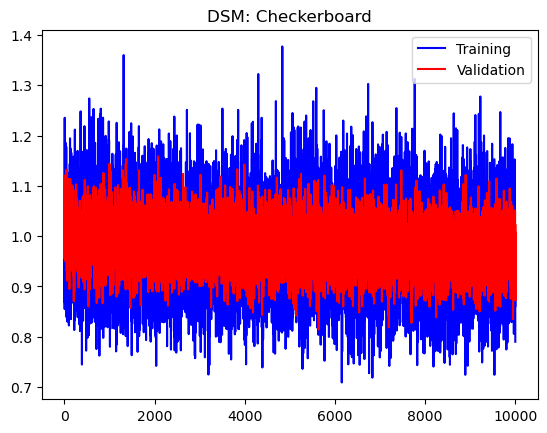

In [7]:
## Loss plots
DSM_training_plot(train_losses, val_losses, title='DSM: Checkerboard')

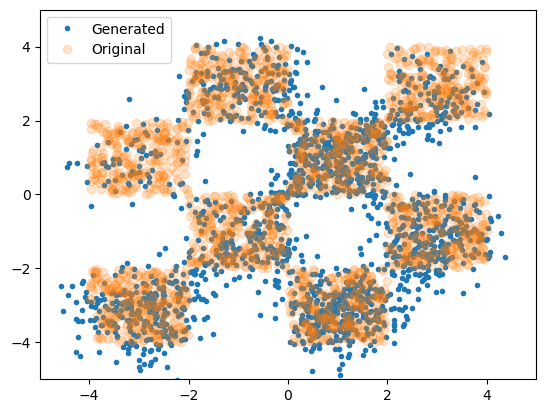

In [8]:
## Generation
dsm_samples = DSM_sampler(params, X_checker, noise, step_size, num_steps, key=prng_seq)

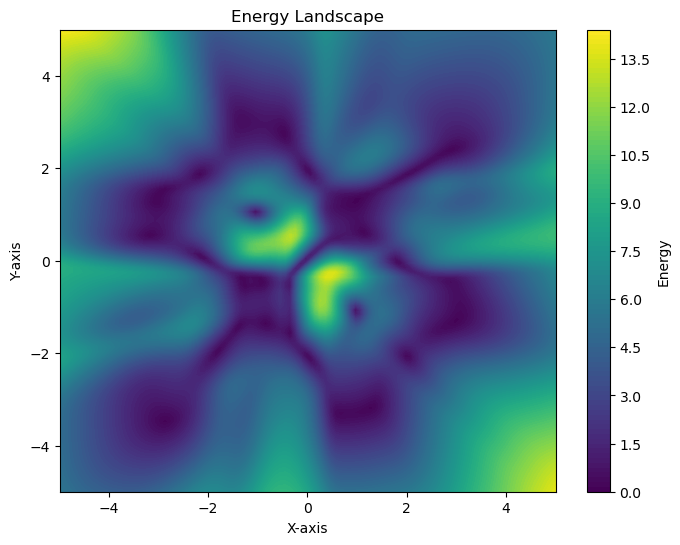

In [9]:
## Energy density plot
'''
Lower energy signifies concentration of probability where datapoints should be.
'''
# Define the range for the grid
grid_x = np.linspace(np.min(X_checker[:, 0])-1, np.max(X_checker[:, 0])+1, 100)
grid_y = np.linspace(np.min(X_checker[:, 1])-1, np.max(X_checker[:, 1])+1, 100)

dsm_plot_energy_landscape(dsm_model, params, grid_x, grid_y)

No. of clean samples = 2000
Mean log(pdf) for DSM generated Checkerboard dataset = -4.029442043221491


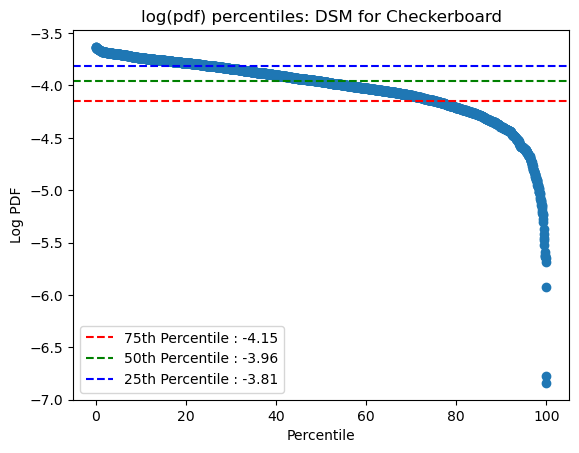

In [10]:
## Gaussian KDE
plot_logpdf(X_checker, dsm_samples, model_name='DSM', dataset_name='Checkerboard')

### 2.2 Denoising Diffusion Probabilistic Model (DDPM)

In [11]:
# to be subtracted from 1.0 for ease of writing
sub_alpha_1 = 1e-4
sub_alpha_T = 0.02
T = 1000
ddpm_model = DDPM_MLP(features=[128, 128, 2], num_steps=T)

print(ddpm_model.tabulate(jax.random.PRNGKey(0), np.zeros((1,2)), 0))


                                DDPM_MLP Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs         ┃ outputs        ┃ params                ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DDPM_MLP │ - float32[1,2] │ float32[1,2]   │                       │
│         │          │ - 0            │                │                       │
├─────────┼──────────┼────────────────┼────────────────┼───────────────────────┤
│ Embed_0 │ Embed    │ int32[1]       │ float32[1,128] │ embedding:            │
│         │          │                │                │ float32[1000,128]     │
│         │          │                │                │                       │
│         │          │                │                │ 128,000 (512.0 KB)    │
├─────────┼──────────┼────────────────┼────────────────┼───────────────────────┤
│ Dense_0 │ Dense    │ floa

In [12]:
## Training
params, train_losses, val_losses, alphas, alphas_cumprod = DDPM_train(
    X_checker, lr=1e-4, clip_norm=0.1, sub_alpha_1=sub_alpha_1,  
    sub_alpha_T=sub_alpha_T, T=T, num_epochs=500000, batch_size=128, key=prng_seq)

100%|██████████| 500000/500000 [40:36<00:00, 205.22it/s]


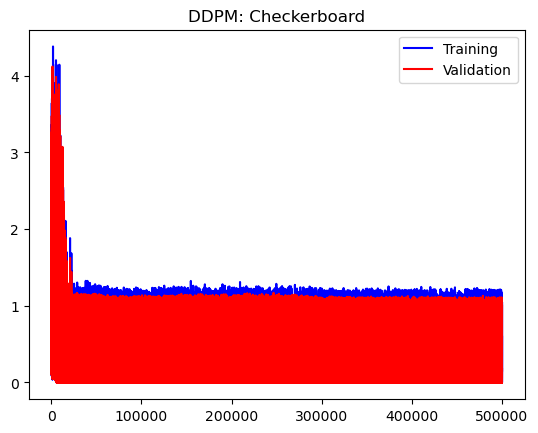

In [13]:
## Loss plots
DDPM_training_plot(train_losses, val_losses, title='DDPM: Checkerboard')

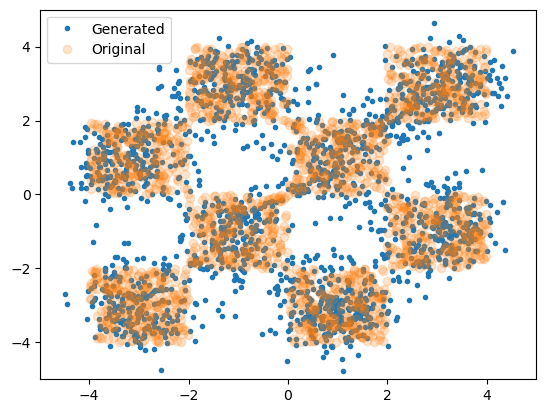

In [14]:
## Generation
ddpm_samples = DDPM_sampler(params, X_checker, noise, alphas, alphas_cumprod)

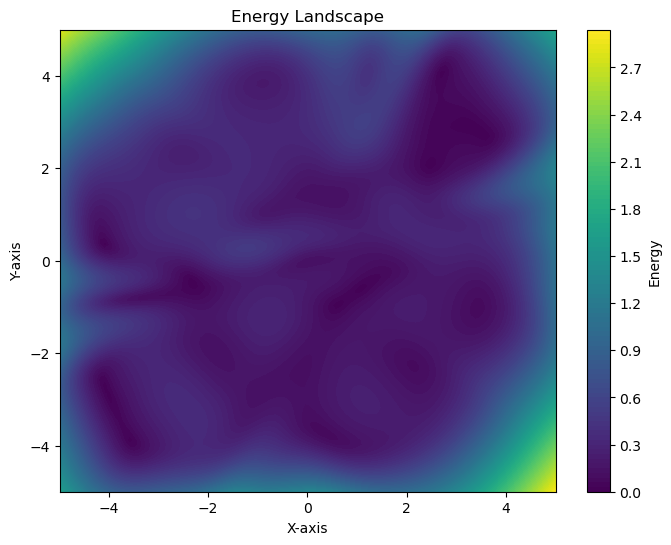

In [15]:
## Energy density plot
'''
Lower energy signifies concentration of probability where datapoints should be.
'''
# Define the range for the grid
grid_x = np.linspace(np.min(X_checker[:, 0])-1, np.max(X_checker[:, 0])+1, 100)
grid_y = np.linspace(np.min(X_checker[:, 1])-1, np.max(X_checker[:, 1])+1, 100)

ddpm_plot_energy_landscape(ddpm_model, params, grid_x, grid_y)

No. of clean samples = 2000
Mean log(pdf) for DDPM generated Checkerboard dataset = -4.036472819393941


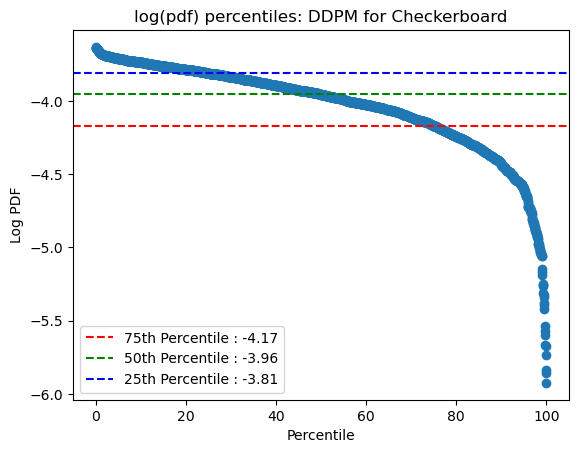

In [16]:
## Gaussian KDE
plot_logpdf(X_checker, ddpm_samples, model_name='DDPM', dataset_name='Checkerboard')

### 2.3 Generative Adversarial Networks (GAN)

In [17]:
generator = GAN_generator(features=[256, 256, 2])
discriminator = GAN_discriminator(features=[256, 256, 1])

print(generator.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))
print(discriminator.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))


                             GAN_generator Summary                              
┏━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module        ┃ inputs         ┃ outputs        ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ GAN_generator │ float32[1,2]   │ float32[1,2]   │                  │
├─────────┼───────────────┼────────────────┼────────────────┼──────────────────┤
│ Dense_0 │ Dense         │ float32[1,2]   │ float32[1,256] │ bias:            │
│         │               │                │                │ float32[256]     │
│         │               │                │                │ kernel:          │
│         │               │                │                │ float32[2,256]   │
│         │               │                │                │                  │
│         │               │                │                │ 768 (3.1 KB)     │
├─────────┼───────────────┼

In [18]:
## Training
gen_params, train_gen_losses, train_disc_losses, val_gen_losses, val_disc_losses = GAN_train(
    X_checker, lr=1e-4, clip_norm=0.1, eps=1e-8, num_epochs=500000, batch_size=64, key=prng_seq
)

100%|██████████| 500000/500000 [1:48:01<00:00, 77.15it/s]


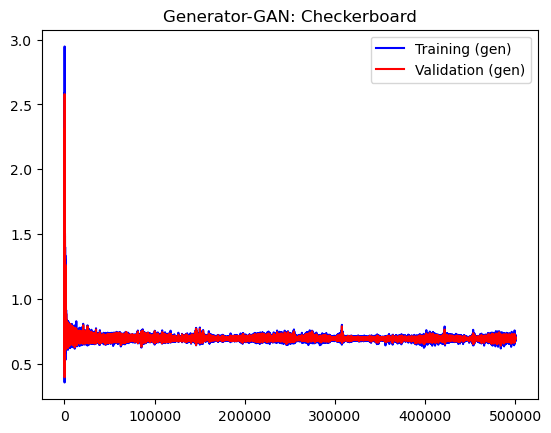

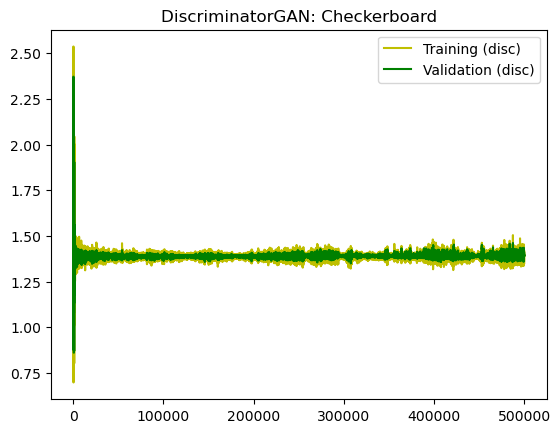

In [19]:
## Loss plots
GAN_training_plot(train_gen_losses, train_disc_losses, val_gen_losses, val_disc_losses, title='GAN: Checkerboard')

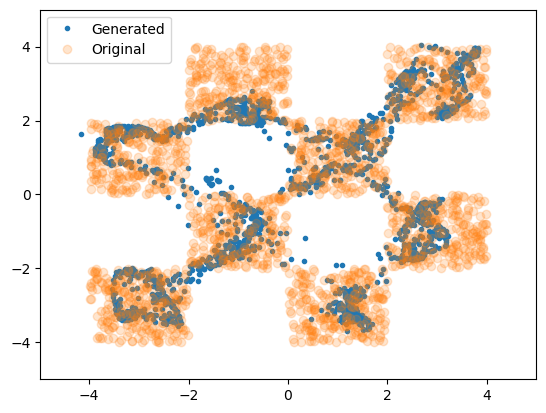

In [20]:
## Generation
gan_samples = GAN_sampler(gen_params, X_checker, noise)

(10000, 2)
(100, 100)


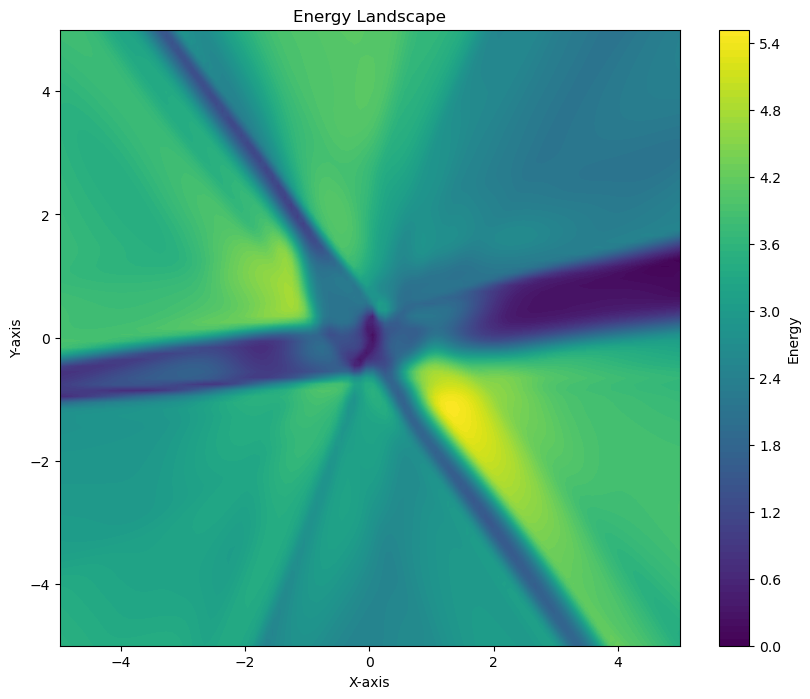

In [21]:
## Energy density plot
'''
Lower energy signifies concentration of probability where datapoints should be.
'''
# Define the range for the grid
grid_x = np.linspace(np.min(X_checker[:, 0])-1, np.max(X_checker[:, 0])+1, 100)
grid_y = np.linspace(np.min(X_checker[:, 1])-1, np.max(X_checker[:, 1])+1, 100)

gan_plot_energy_landscape(generator, gen_params, grid_x, grid_y)

No. of clean samples = 2000
Mean log(pdf) for GAN generated Checkerboard dataset = -3.9356092398812845


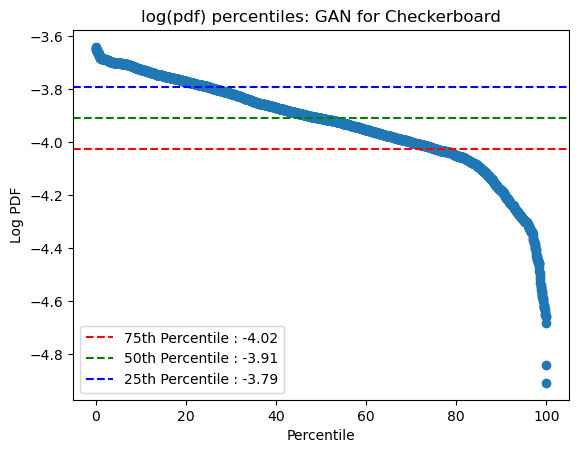

In [22]:
## Gaussian KDE
plot_logpdf(X_checker, gan_samples, model_name='GAN', dataset_name='Checkerboard')

### 2.4 Energy Based Model (EBM)

In [23]:
# The last layer has a single output for energy
ebm_model = EBM_MLP(features=[64, 64, 1], out_activation=None)
step_size = 5e-3
num_steps = 1000

print(ebm_model.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))


                               EBM_MLP Summary                                
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs        ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ EBM_MLP │ float32[1,2]  │ float32[1,1]  │                        │
├─────────┼─────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_0 │ Dense   │ float32[1,2]  │ float32[1,64] │ bias: float32[64]      │
│         │         │               │               │ kernel: float32[2,64]  │
│         │         │               │               │                        │
│         │         │               │               │ 192 (768 B)            │
├─────────┼─────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_1 │ Dense   │ float32[1,64] │ float32[1,64] │ bias: float32[64]      │
│         │         │               │              

In [24]:
## Training
params, train_losses, val_losses = EBM_train(X_checker, lr=1e-3, clip_norm=0.1, 
                                     l2=0.1, num_epochs=2000, batch_size=128, key=prng_seq)

100%|██████████| 2000/2000 [29:43<00:00,  1.12it/s]


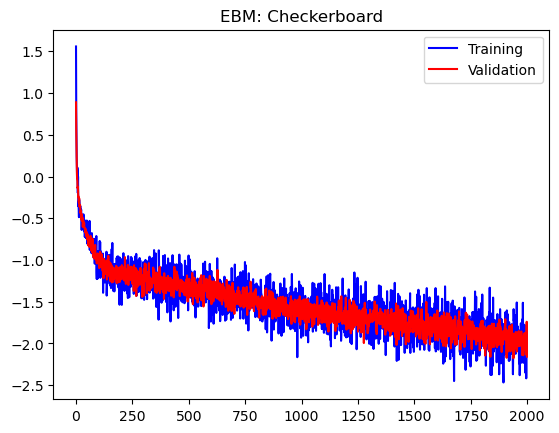

In [25]:
## Loss plots
EBM_training_plot(train_losses, val_losses, title='EBM: Checkerboard')

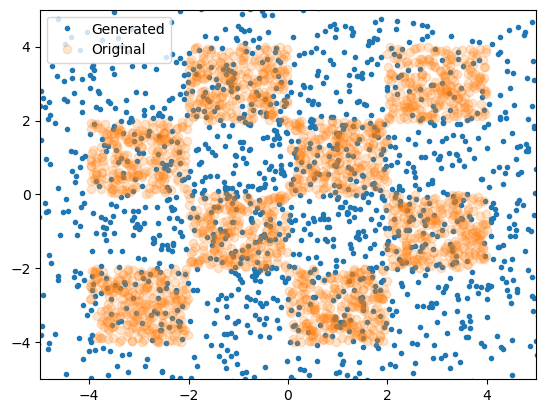

In [26]:
## Generation
ebm_samples = EBM_sampler(params, X_checker, noise, step_size, num_steps, key=prng_seq)

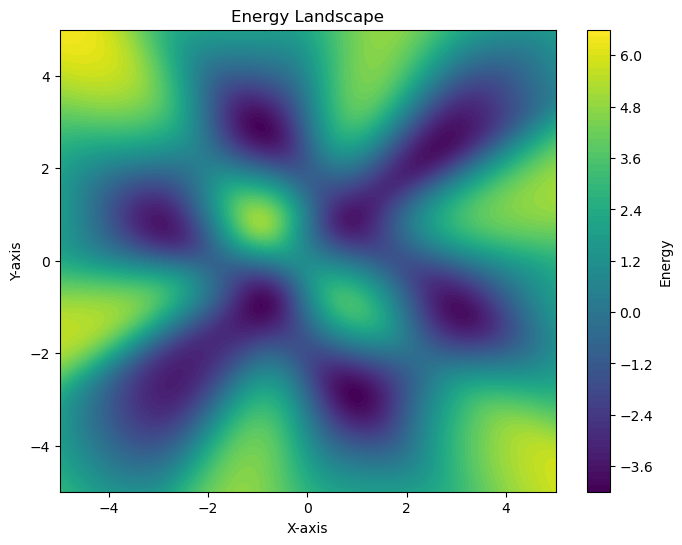

In [27]:
## Energy density plot
'''
Lower energy signifies concentration of probability where datapoints should be.
'''
# Define the range for the grid
grid_x = np.linspace(np.min(X_checker[:, 0])-1, np.max(X_checker[:, 0])+1, 100)
grid_y = np.linspace(np.min(X_checker[:, 1])-1, np.max(X_checker[:, 1])+1, 100)

ebm_plot_energy_landscape(ebm_model, params, grid_x, grid_y)

No. of clean samples = 2000
Mean log(pdf) for EBM generated Checkerboard dataset = -10.578381889298816


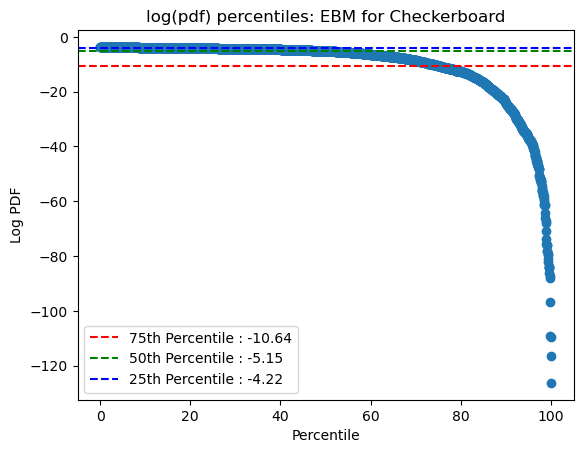

In [28]:
## Gaussian KDE
plot_logpdf(X_checker, ebm_samples, model_name='EBM', dataset_name='Checkerboard')